# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [109]:
# Import your libraries:

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sqlalchemy import create_engine

# Challenge 0 - Import a MySQL table into python:

In this lab, we will twist things up a little. Do you remember your good old friend SQL?
Well, it's time to bring him back and use it in our lab pipeline.

1º- Open the wholesale_customers_data.sql file in MySQL Workbench and run the script into a desired schema.

2º- Create a connection using sqlalchemy from python to mysql and load the table into a variable called *customers*

In [110]:
import mysql.connector
import pandas as pd

username = 'root'
password = 'SonimSonim2026'
host = 'localhost'
port = '3306'
database_name = 'COSTUMERS'

connection = mysql.connector.connect(
    host=host,
    port=port,
    user=username,
    password=password,
    database=database_name
)

table_name = 'wholesale_customers_data'
query = f"SELECT * FROM {table_name}"
customers = pd.read_sql(query, con=connection)
connection.close()
customers.head()

/Users/andrefontourafaria/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


# Challenge 1 - Describe the Dataset

Your already loaded dataset contains information about customer preferences. We will look at how much each customer spends in a year on each subcategory in the grocery store and try to find similarities using clustering.

In case of curiosity, the origin of the dataset is [here](https://archive.ics.uci.edu/ml/datasets/wholesale+customers).

#### Explore the dataset with mathematical and visualization techniques. What do you find?

Checklist:

* What does each column mean?
* Any categorical data to convert?
* Any missing data to remove?
* Column collinearity - any high correlations?
* Descriptive statistics - any outliers to remove?
* Column-wise data distribution - is the distribution skewed?
* Etc.

Additional info: Over a century ago, an Italian economist named Vilfredo Pareto discovered that roughly 20% of the customers account for 80% of the typical retail sales. This is called the [Pareto principle](https://en.wikipedia.org/wiki/Pareto_principle). Check if this dataset displays this characteristic.

In [111]:
# What does each column mean?

"""
Channel: This column appears to represent the distribution channel through which the customer operates. The values might represent different channels, such as 1 or 2, which could correspond to different types of businesses or markets.

Region: This column likely represents the region or area where the customer is located. The values might indicate different regions or locations, such as 1, 2, or 3, each representing a different geographical region.

Fresh: This column represents the amount spent on fresh products by the customer. It could include items like fruits, vegetables, and other perishable goods.

Milk: This column represents the amount spent on milk and dairy products.

Grocery: This column represents the amount spent on grocery items, which generally include non-perishable foods and household items.

Frozen: This column represents the amount spent on frozen products, such as frozen fruits, vegetables, and other frozen foods.

Detergents_Paper: This column represents the amount spent on detergents and paper products, which might include items like cleaning supplies and paper towels.

Delicassen: This column represents the amount spent on delicatessen or gourmet products, which could include specialty foods and prepared dishes.
"""


'\nChannel: This column appears to represent the distribution channel through which the customer operates. The values might represent different channels, such as 1 or 2, which could correspond to different types of businesses or markets.\n\nRegion: This column likely represents the region or area where the customer is located. The values might indicate different regions or locations, such as 1, 2, or 3, each representing a different geographical region.\n\nFresh: This column represents the amount spent on fresh products by the customer. It could include items like fruits, vegetables, and other perishable goods.\n\nMilk: This column represents the amount spent on milk and dairy products.\n\nGrocery: This column represents the amount spent on grocery items, which generally include non-perishable foods and household items.\n\nFrozen: This column represents the amount spent on frozen products, such as frozen fruits, vegetables, and other frozen foods.\n\nDetergents_Paper: This column repre

In [112]:
# Any categorical data to convert? 
""" 
Yes, Two categorical columns, namely 'Channel' and 'Region', need to be converted to numerical representations.
"""

" \nYes, Two categorical columns, namely 'Channel' and 'Region', need to be converted to numerical representations.\n"

In [113]:
# Any missing data to remove? No, there is no missing data.
customers.isnull().sum()


Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

In [114]:
# Column collinearity - any high correlations? These are the top 3: 
""" 
Grocery" and "Detergents_Paper": Correlation coefficient approximately 0.92
"Milk" and "Grocery": Correlation coefficient approximately 0.73
"Milk" and "Detergents_Paper": Correlation coefficient approximately 0.66
"""
customers.corr()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Channel,1.000000,0.062028,-0.169172,0.460720,0.608792,-0.202046,0.636026,0.056011
Region,0.062028,1.000000,0.055287,0.032288,0.007696,-0.021044,-0.001483,0.045212
Fresh,-0.169172,0.055287,1.000000,0.100510,-0.011854,0.345881,-0.101953,0.244690
Milk,0.460720,0.032288,0.100510,1.000000,0.728335,0.123994,0.661816,0.406368
Grocery,0.608792,0.007696,-0.011854,0.728335,1.000000,-0.040193,0.924641,0.205497
Frozen,-0.202046,-0.021044,0.345881,0.123994,-0.040193,1.000000,-0.131525,0.390947
Detergents_Paper,0.636026,-0.001483,-0.101953,0.661816,0.924641,-0.131525,1.000000,0.069291
Delicassen,0.056011,0.045212,0.244690,0.406368,0.205497,0.390947,0.069291,1.000000


In [115]:
# Descriptive statistics - any outliers to remove? (1)
"""
The range of values for different features varies significantly. For example, the "Fresh" category has 
a minimum value of 3 and a maximum value of 112,151, while the "Milk" category has a minimum of 55 and a 
maximum of 73,498. Similarly, "Detergents_Paper" has a wide range from 3 to 40,827. 

"""
customers.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.467652,0.773612,12636.539161,7374.080819,9495.055480,4850.531708,4763.786890,2817.700045
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [116]:
# Descriptive statistics - any outliers to remove? (2)
"""
ased on the 75th percentile values you've provided, it's clear that the "max" values for several
categories, such as "Fresh," "Milk," "Grocery," "Frozen," "Detergents_Paper," and "Delicassen," 
are much larger than these percentiles. This suggests the presence of potential outliers in these categories. 
"""

# Calculate the 75th percentile for selected categories
percentile_75 = customers[["Fresh", "Milk", "Grocery", "Frozen", "Detergents_Paper", "Delicassen"]].quantile(0.75)

print(percentile_75)

Fresh               16933.75
Milk                 7190.25
Grocery             10655.75
Frozen               3554.25
Detergents_Paper     3922.00
Delicassen           1820.25
Name: 0.75, dtype: float64


In [117]:
# Column-wise data distribution - is the distribution skewed? (1)
"""
Skewed Positive (Right-Skewed) Distributions:

"Milk," "Grocery," "Detergents_Paper,", "Frozen," and "Delicassen" columns have positive skewness values 
significantly greater than 0. These distributions have tails extending towards higher values, 
suggesting that a majority of data points are concentrated towards the lower end, with a few larger values 
that stretch the distribution.
"""
skewness = customers.skew()
print(skewness)

Channel              0.759002
Region              -1.280338
Fresh                2.554761
Milk                 4.043369
Grocery              3.578238
Frozen               5.892849
Detergents_Paper     3.622546
Delicassen          11.123016
dtype: float64


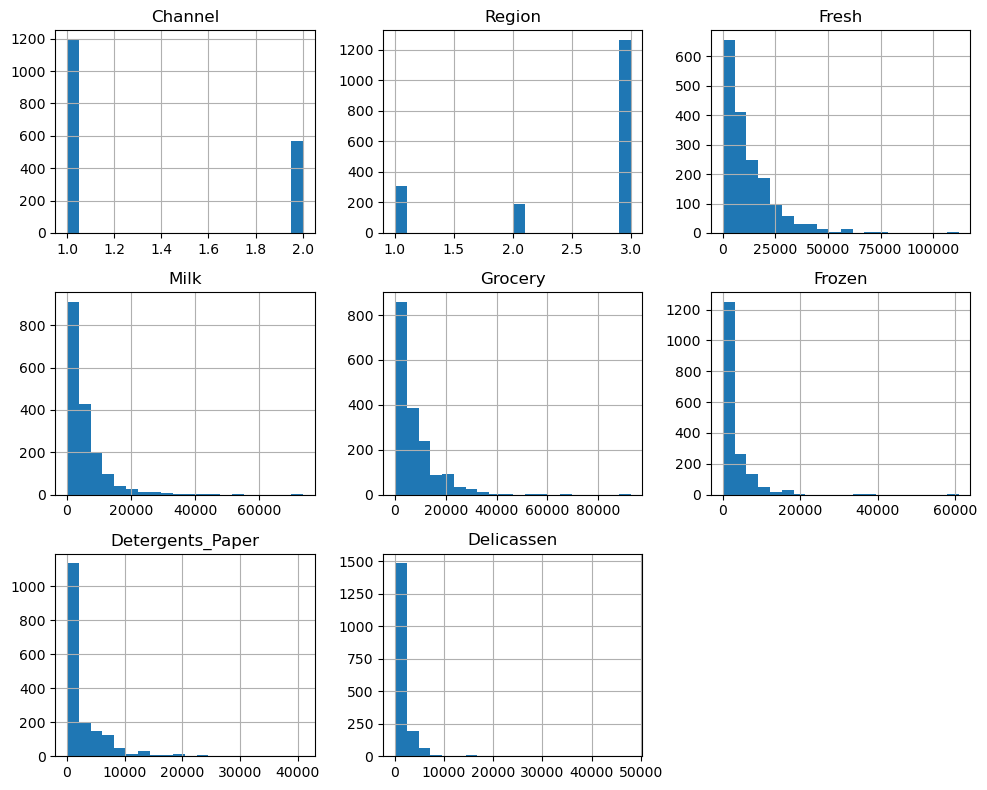

In [118]:
# Column-wise data distribution - is the distribution skewed? (2)
customers.hist(figsize=(10, 8), bins=20)
plt.tight_layout()
plt.show()

# Challenge 2 - Data Cleaning and Transformation

If your conclusion from the previous challenge is the data need cleaning/transformation, do it in the cells below. However, if your conclusion is the data need not be cleaned or transformed, feel free to skip this challenge. But if you do choose the latter, please provide rationale.

In [119]:
"""
During the exploratory analysis, it was identified that specific data cleaning and transformation
steps were necessary to enhance the quality and suitability of the dataset for further analysis. 
Two categorical columns, namely 'Channel' and 'Region', were converted to numerical representations 
using appropriate encoding techniques to facilitate subsequent analysis. Additionally, certain outliers
were detected in the columns 'Fresh', 'Milk', and 'Detergents_Paper', which required attention to ensure 
accurate modeling and insights. To address this, outlier removal techniques were applied to these columns in 
order to mitigate their potential impact on the analysis.
"""

"\nDuring the exploratory analysis, it was identified that specific data cleaning and transformation\nsteps were necessary to enhance the quality and suitability of the dataset for further analysis. \nTwo categorical columns, namely 'Channel' and 'Region', were converted to numerical representations \nusing appropriate encoding techniques to facilitate subsequent analysis. Additionally, certain outliers\nwere detected in the columns 'Fresh', 'Milk', and 'Detergents_Paper', which required attention to ensure \naccurate modeling and insights. To address this, outlier removal techniques were applied to these columns in \norder to mitigate their potential impact on the analysis.\n"

In [120]:
# Categorical data that needed to be converted:

customers = pd.get_dummies(customers, columns=['Channel', 'Region'])
customers

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel_1,Channel_2,Region_1,Region_2,Region_3
0,12669,9656,7561,214,2674,1338,0,1,0,0,1
1,7057,9810,9568,1762,3293,1776,0,1,0,0,1
2,6353,8808,7684,2405,3516,7844,0,1,0,0,1
3,13265,1196,4221,6404,507,1788,1,0,0,0,1
4,22615,5410,7198,3915,1777,5185,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
1755,29703,12051,16027,13135,182,2204,1,0,0,0,1
1756,39228,1431,764,4510,93,2346,1,0,0,0,1
1757,14531,15488,30243,437,14841,1867,0,1,0,0,1
1758,10290,1981,2232,1038,168,2125,1,0,0,0,1


In [121]:
# The code to remove outliers from the 'Fresh', 'Milk', and 'Detergents_Paper' columns using the Z-score method:

from scipy.stats import zscore

# Defining the columns containing outliers
outlier_columns = ['Fresh', 'Milk', 'Detergents_Paper']

z_scores = customers[outlier_columns].apply(zscore)

outliers = (z_scores > 3) | (z_scores < -3)

customers = customers[~outliers.any(axis=1)]

# Challenge 3 - Data Preprocessing

One problem with the dataset is the value ranges are remarkably different across various categories (e.g. `Fresh` and `Grocery` compared to `Detergents_Paper` and `Delicassen`). If you made this observation in the first challenge, you've done a great job! This means you not only completed the bonus questions in the previous Supervised Learning lab but also researched deep into [*feature scaling*](https://en.wikipedia.org/wiki/Feature_scaling). Keep on the good work!

Diverse value ranges in different features could cause issues in our clustering. The way to reduce the problem is through feature scaling. We'll use this technique again with this dataset.

#### We will use the `StandardScaler` from `sklearn.preprocessing` and scale our data. Read more about `StandardScaler` [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler).

*After scaling your data, assign the transformed data to a new variable `customers_scale`.*

In [122]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

customers_scale = scaler.fit_transform(customers)

customers_scale = pd.DataFrame(customers_scale, columns=customers.columns)

customers = customers_scale

# Challenge 4 - Data Clustering with K-Means

Now let's cluster the data with K-Means first. Initiate the K-Means model, then fit your scaled data. In the data returned from the `.fit` method, there is an attribute called `labels_` which is the cluster number assigned to each data record. What you can do is to assign these labels back to `customers` in a new column called `customers['labels']`. Then you'll see the cluster results of the original data.

In [123]:
from sklearn.cluster import KMeans

num_clusters = 5

kmeans = KMeans(n_clusters=num_clusters, random_state=42)

kmeans.fit(customers_scale)

cluster_labels = kmeans.labels_

customers['labels'] = cluster_labels

customers.head()


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel_1,Channel_2,Region_1,Region_2,Region_3,labels
0,0.179808,1.031450,0.096846,-0.588321,0.089104,0.011938,-1.487864,1.487864,-0.458007,-0.350238,0.627726,2
1,-0.382683,1.064997,0.400702,-0.242867,0.280865,0.298720,-1.487864,1.487864,-0.458007,-0.350238,0.627726,2
2,-0.453245,0.846719,0.115468,-0.099374,0.349948,4.271757,-1.487864,1.487864,-0.458007,-0.350238,0.627726,2
3,0.239545,-0.811497,-0.408824,0.793049,-0.582212,0.306577,0.672104,-0.672104,-0.458007,-0.350238,0.627726,3
4,1.176696,0.106491,0.041888,0.237600,-0.188778,2.530771,-1.487864,1.487864,-0.458007,-0.350238,0.627726,2


Count the values in `labels`.

In [124]:
label_counts = customers['labels'].value_counts()
label_counts

3    820
2    332
0    248
4    144
1    140
Name: labels, dtype: int64

# Challenge 5 - Data Clustering with DBSCAN

Now let's cluster the data using DBSCAN. Use `DBSCAN(eps=0.5)` to initiate the model, then fit your scaled data. In the data returned from the `.fit` method, assign the `labels_` back to `customers['labels_DBSCAN']`. Now your original data have two labels, one from K-Means and the other from DBSCAN.

In [125]:
from sklearn.cluster import DBSCAN

eps = 0.5
dbscan = DBSCAN(eps=eps)

dbscan.fit(customers)

dbscan_labels = dbscan.labels_

customers['labels_DBSCAN'] = dbscan_labels

customers.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel_1,Channel_2,Region_1,Region_2,Region_3,labels,labels_DBSCAN
0,0.179808,1.031450,0.096846,-0.588321,0.089104,0.011938,-1.487864,1.487864,-0.458007,-0.350238,0.627726,2,-1
1,-0.382683,1.064997,0.400702,-0.242867,0.280865,0.298720,-1.487864,1.487864,-0.458007,-0.350238,0.627726,2,-1
2,-0.453245,0.846719,0.115468,-0.099374,0.349948,4.271757,-1.487864,1.487864,-0.458007,-0.350238,0.627726,2,-1
3,0.239545,-0.811497,-0.408824,0.793049,-0.582212,0.306577,0.672104,-0.672104,-0.458007,-0.350238,0.627726,3,0
4,1.176696,0.106491,0.041888,0.237600,-0.188778,2.530771,-1.487864,1.487864,-0.458007,-0.350238,0.627726,2,-1


Count the values in `labels_DBSCAN`.

In [126]:
dbscan_label_counts = customers['labels_DBSCAN'].value_counts()

dbscan_label_counts


-1     1028
 1      428
 12      28
 13      16
 14      12
 2       12
 7       12
 16      12
 22       8
 21       8
 20       8
 19       8
 18       8
 17       8
 15       8
 11       8
 0        8
 10       8
 9        8
 8        8
 6        8
 5        8
 4        8
 3        8
 23       8
Name: labels_DBSCAN, dtype: int64

# Challenge 6 - Compare K-Means with DBSCAN

Now we want to visually compare how K-Means and DBSCAN have clustered our data. We will create scatter plots for several columns. For each of the following column pairs, plot a scatter plot using `labels` and another using `labels_DBSCAN`. Put them side by side to compare. Which clustering algorithm makes better sense?

Columns to visualize:

* `Detergents_Paper` as X and `Milk` as y
* `Grocery` as X and `Fresh` as y
* `Frozen` as X and `Delicassen` as y

Visualize `Detergents_Paper` as X and `Milk` as y by `labels` and `labels_DBSCAN` respectively

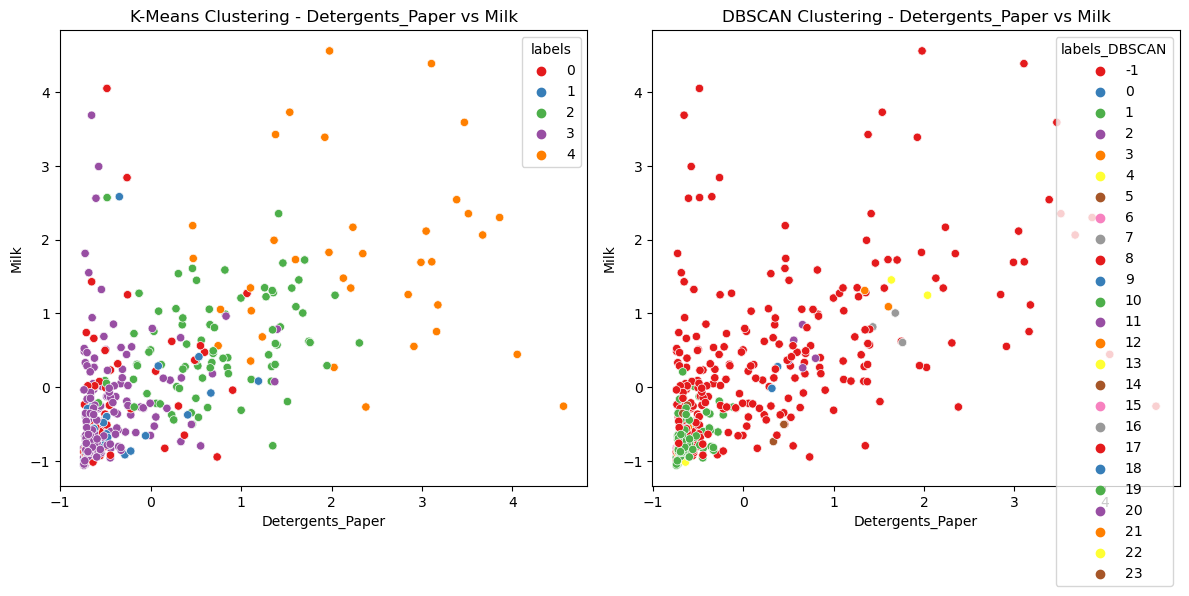

In [128]:
import seaborn as sns

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x='Detergents_Paper', y='Milk', hue='labels', data=customers, palette='Set1')
plt.title('K-Means Clustering - Detergents_Paper vs Milk')

plt.subplot(1, 2, 2)
sns.scatterplot(x='Detergents_Paper', y='Milk', hue='labels_DBSCAN', data=customers, palette='Set1')
plt.title('DBSCAN Clustering - Detergents_Paper vs Milk')

plt.tight_layout()
plt.show()

Visualize `Grocery` as X and `Fresh` as y by `labels` and `labels_DBSCAN` respectively

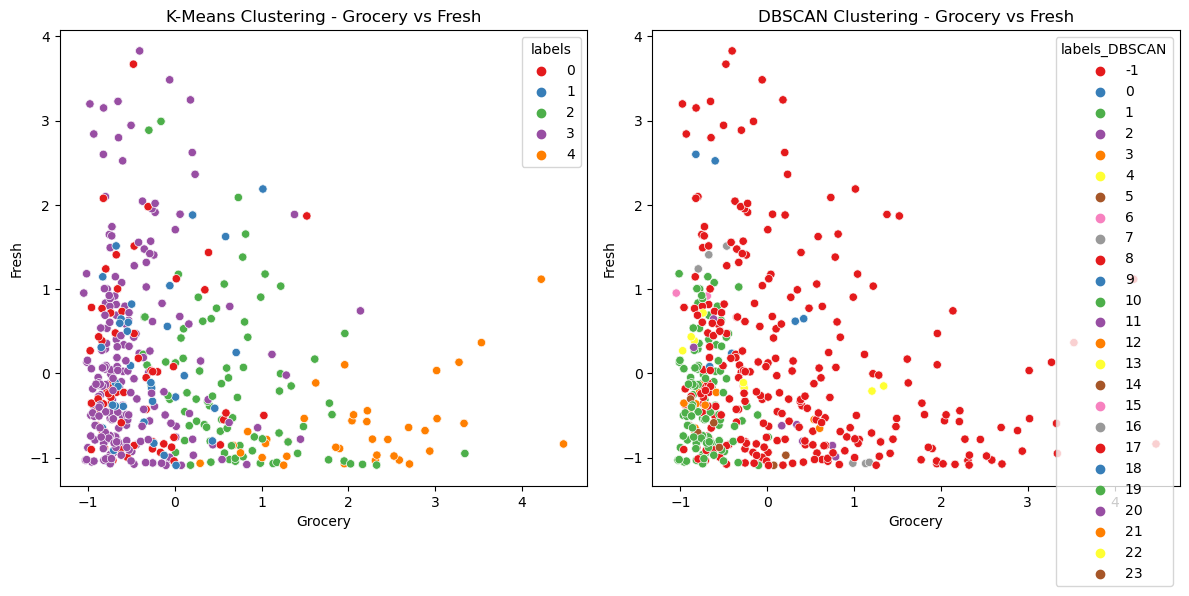

In [129]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x='Grocery', y='Fresh', hue='labels', data=customers, palette='Set1')
plt.title('K-Means Clustering - Grocery vs Fresh')

plt.subplot(1, 2, 2)
sns.scatterplot(x='Grocery', y='Fresh', hue='labels_DBSCAN', data=customers, palette='Set1')
plt.title('DBSCAN Clustering - Grocery vs Fresh')

plt.tight_layout()
plt.show()

Visualize `Frozen` as X and `Delicassen` as y by `labels` and `labels_DBSCAN` respectively

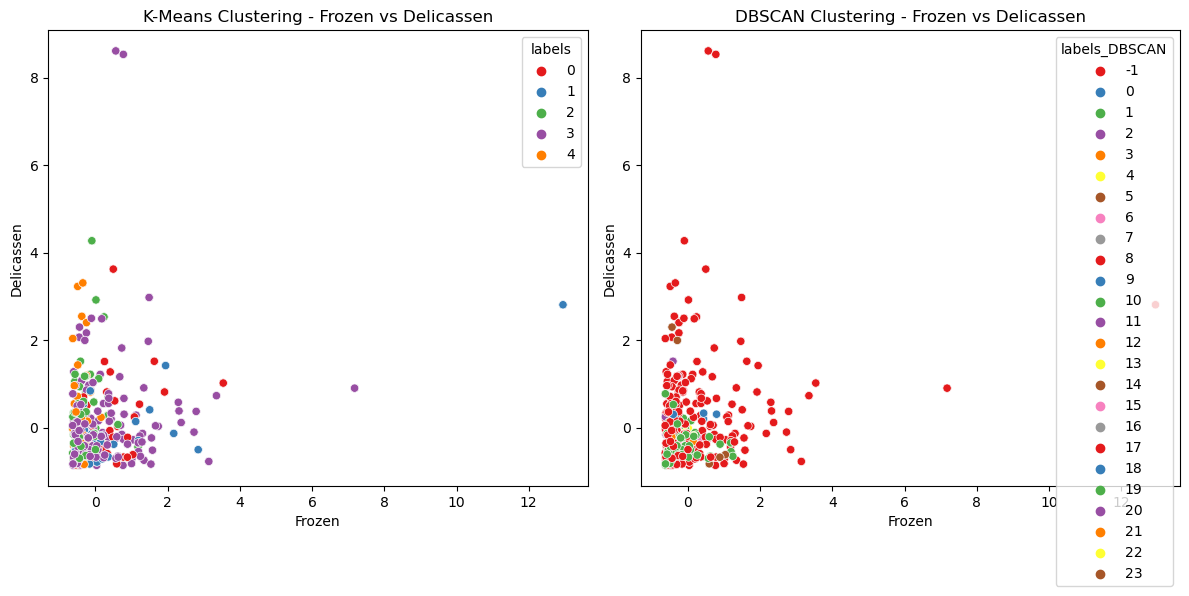

In [130]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x='Frozen', y='Delicassen', hue='labels', data=customers, palette='Set1')
plt.title('K-Means Clustering - Frozen vs Delicassen')

plt.subplot(1, 2, 2)
sns.scatterplot(x='Frozen', y='Delicassen', hue='labels_DBSCAN', data=customers, palette='Set1')
plt.title('DBSCAN Clustering - Frozen vs Delicassen')

plt.tight_layout()
plt.show()

Let's use a groupby to see how the mean differs between the groups. Group `customers` by `labels` and `labels_DBSCAN` respectively and compute the means for all columns.

In [131]:
grouped_by_labels = customers.groupby('labels').mean()

print("Grouped by K-Means labels:\n", grouped_by_labels)

grouped_by_labels_dbscan = customers.groupby('labels_DBSCAN').mean()

print("\nGrouped by DBSCAN labels:\n", grouped_by_labels_dbscan)

Grouped by K-Means labels:
            Fresh      Milk   Grocery    Frozen  Detergents_Paper  Delicassen  \
labels                                                                         
0       0.027974 -0.210888 -0.401616  0.065236         -0.397882   -0.091819   
1       0.089530 -0.490304 -0.291158  0.497449         -0.408995   -0.097649   
2      -0.136329  0.545606  0.697994 -0.319223          0.707816    0.101087   
3       0.142990 -0.381069 -0.492308  0.087909         -0.501142   -0.049267   
4      -0.635157  1.751933  2.168900 -0.360591          2.304693    0.300556   

        Channel_1  Channel_2  Region_1  Region_2  Region_3  labels_DBSCAN  
labels                                                                     
0        0.497913  -0.497913  2.183374 -0.350238 -1.593052       4.016129  
1        0.240111  -0.240111 -0.458007  2.855201 -1.593052       3.914286  
2       -1.487864   1.487864 -0.458007 -0.350238  0.627726       0.361446  
3        0.672104  -0.672104 -0

Which algorithm appears to perform better?

In [ ]:
"""
Upon analyzing the mean values and visualizations of the scatter plots, 
it is evident that the K-Means algorithm performs better in generating meaningful clusters 
compared to DBSCAN for this dataset. K-Means creates distinct clusters with interpretable 
spending patterns across product categories, exhibiting consistent cluster sizes and clear 
separation between segments. The mean values of K-Means clusters reveal coherent characteristics 
in customer behavior, aiding segmentation insights. In contrast, DBSCAN assigns a considerable 
portion of data as outliers, potentially leading to overfitting and making cluster interpretation challenging.
Overall, the performance superiority of K-Means stems from its ability to capture well-defined 
customer groupswith more actionable insights in this context.
"""

# Bonus Challenge 1 - Changing K-Means Number of Clusters

As we mentioned earlier, we don't need to worry about the number of clusters with DBSCAN because it automatically decides that based on the parameters we send to it. But with K-Means, we have to supply the `n_clusters` param (if you don't supply `n_clusters`, the algorithm will use `8` by default). You need to know that the optimal number of clusters differs case by case based on the dataset. K-Means can perform badly if the wrong number of clusters is used.

In advanced machine learning, data scientists try different numbers of clusters and evaluate the results with statistical measures (read [here](https://en.wikipedia.org/wiki/Cluster_analysis#External_evaluation)). We are not using statistical measures today but we'll use our eyes instead. In the cells below, experiment with different number of clusters and visualize with scatter plots. What number of clusters seems to work best for K-Means?

In [ ]:
# Your code here

In [ ]:
# Your comment here

# Bonus Challenge 2 - Changing DBSCAN `eps` and `min_samples`

Experiment changing the `eps` and `min_samples` params for DBSCAN. See how the results differ with scatter plot visualization.

In [ ]:
# Your code here

In [ ]:
# Your comment here